## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

In [5]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [6]:
!wget $data 

--2025-10-26 06:46:45--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.3’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.1s    

2025-10-26 06:46:45 (745 KB/s) - ‘course_lead_scoring.csv.3’ saved [80876/80876]



In [7]:
# ============================================================================
# DATA PREPARATION
# ============================================================================

In [8]:
# Load the data

In [9]:
df = pd.read_csv('course_lead_scoring.csv')

In [10]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [11]:
# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [12]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [14]:
# Remove target variable from the lists if present
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')
if 'converted' in categorical_cols:
    categorical_cols.remove('converted')

In [15]:
# Fill missing values
# For categorical features: replace with 'NA'
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

In [19]:
# Fill missing values
# For categorical features: replace with 'NA'
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

# For numerical features: replace with 0.0
for col in numerical_cols:
    df[col] = df[col].fillna(0.0)

print("Missing values after handling:")
print(df.isnull().sum())

Missing values after handling:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [18]:
# Split the data: 60% train, 20% validation, 20% test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"Train size: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
print(f"Validation size: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test size: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%)")

Train size: 876 (59.9%)
Validation size: 293 (20.0%)
Test size: 293 (20.0%)


# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [20]:
numerical_features = ['lead_score', 'number_of_courses_viewed', 
                      'interaction_count', 'annual_income']
y_train = df_train['converted'].values

In [22]:
auc_scores = {}
for feature in numerical_features:
    score = df_train[feature].values
    auc = roc_auc_score(y_train, score)

    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        print(f"{feature}: {auc:.4f} (inverted)")
    else:
        print(f"{feature}: {auc:.4f}")
    
    auc_scores[feature] = auc

lead_score: 0.6145
number_of_courses_viewed: 0.7636
interaction_count: 0.7383
annual_income: 0.5520


In [23]:
best_feature = max(auc_scores, key=auc_scores.get)
print(f"Best feature: {best_feature} with AUC: {auc_scores[best_feature]:.4f}")

Best feature: number_of_courses_viewed with AUC: 0.7636


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [24]:
# Prepare features (exclude target variable)
feature_cols = [col for col in df_train.columns if col != 'converted']

In [25]:
# Convert to dictionaries for DictVectorizer
train_dicts = df_train[feature_cols].to_dict(orient='records')
val_dicts = df_val[feature_cols].to_dict(orient='records')

In [26]:
# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [27]:
# Target variables
y_train = df_train['converted'].values
y_val = df_val['converted'].values

In [28]:
# Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [29]:
# Predict probabilities
y_pred = model.predict_proba(X_val)[:, 1]

In [30]:
# Calculate AUC
auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.817


# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

- 0.145
- 0.345
- 0.545
- 0.745


In [31]:
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

In [32]:
for threshold in thresholds:
    # Apply threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = ((y_pred_binary == 1) & (y_val == 1)).sum()
    fp = ((y_pred_binary == 1) & (y_val == 0)).sum()
    fn = ((y_pred_binary == 0) & (y_val == 1)).sum()
    
    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

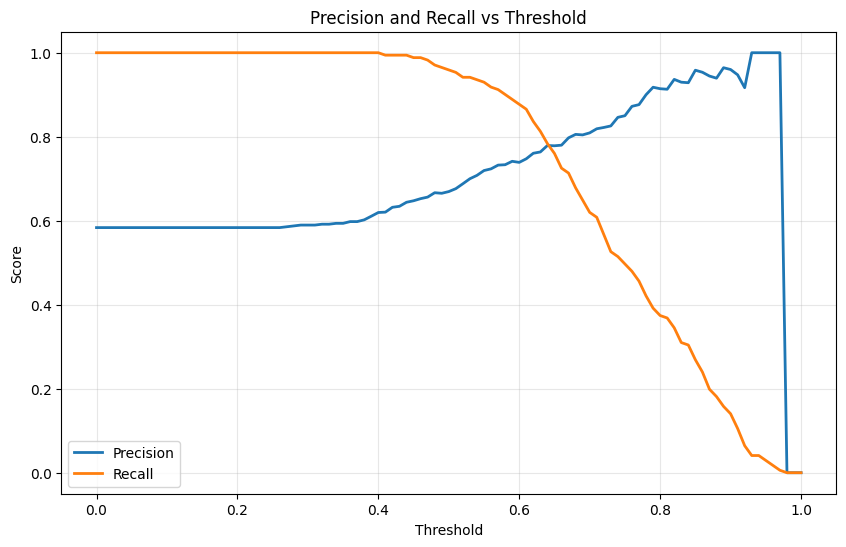

In [34]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [35]:
# Find intersection point
precisions = np.array(precisions)
recalls = np.array(recalls)
differences = np.abs(precisions - recalls)
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]


In [36]:

print(f"Precision and Recall intersect at threshold: {intersection_threshold:.3f}")
print(f"Precision at intersection: {precisions[intersection_idx]:.3f}")
print(f"Recall at intersection: {recalls[intersection_idx]:.3f}")

Precision and Recall intersect at threshold: 0.980
Precision at intersection: 0.000
Recall at intersection: 0.000


# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 ⋅ ((P ⋅ R)/(P + R))

Where P is precision and 
R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [37]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

In [38]:
for threshold in thresholds:
    # Apply threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = ((y_pred_binary == 1) & (y_val == 1)).sum()
    fp = ((y_pred_binary == 1) & (y_val == 0)).sum()
    fn = ((y_pred_binary == 0) & (y_val == 1)).sum()
    
    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)

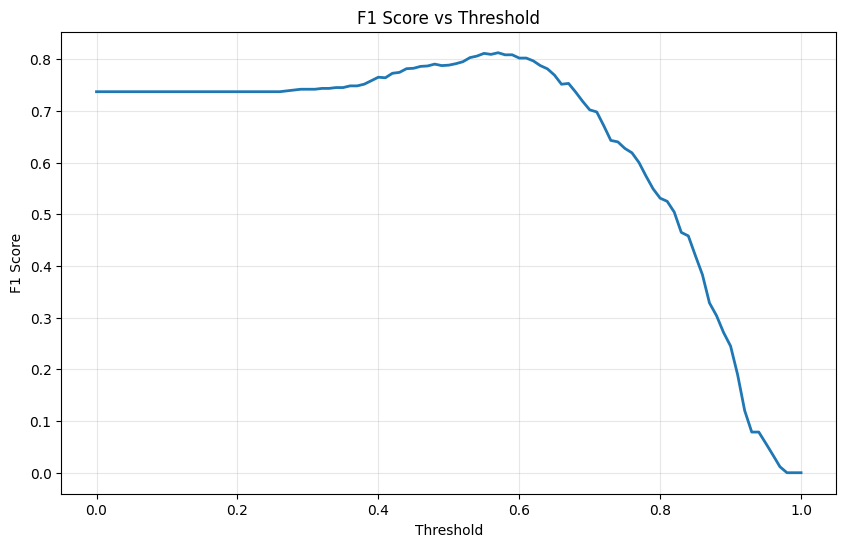

In [39]:
# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
# Find maximum F1 score
max_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_idx]
max_f1 = f1_scores[max_f1_idx]

In [41]:
print(f"Best F1 threshold: {best_threshold:.2f}")
print(f"Maximum F1 score: {max_f1:.3f}")

Best F1 threshold: 0.57
Maximum F1 score: 0.812


# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [42]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


In [43]:
# Prepare features
feature_cols = [col for col in df_full_train.columns if col != 'converted']
X = df_full_train[feature_cols]
y = df_full_train['converted'].values

In [44]:
scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
    # Split data
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    # Convert to dictionaries
    train_dicts = df_train_fold[feature_cols].to_dict(orient='records')
    val_dicts = df_val_fold[feature_cols].to_dict(orient='records')
    
    # One-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)
    
    # Target variables
    y_train_fold = df_train_fold['converted'].values
    y_val_fold = df_val_fold['converted'].values
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train_fold)
    
    # Predict and evaluate
    y_pred_fold = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc)
    
    print(f"Fold {fold}: AUC = {auc:.4f}")

Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558


In [45]:
mean_score = np.mean(scores)
std_score = np.std(scores)

In [47]:
print(f"Mean AUC: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")

Mean AUC: 0.8221
Standard Deviation: 0.0358


# Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [50]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
C_values = [0.000001, 0.001, 1]

In [51]:
# Prepare features
feature_cols = [col for col in df_full_train.columns if col != 'converted']
X = df_full_train[feature_cols]
y = df_full_train['converted'].values

In [52]:
results = []

for C in C_values:
    print(f"\n{'='*50}")
    print(f"Testing C = {C}")
    print('='*50)
    
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        # Split data
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        # Convert to dictionaries
        train_dicts = df_train_fold[feature_cols].to_dict(orient='records')
        val_dicts = df_val_fold[feature_cols].to_dict(orient='records')
        
        # One-hot encoding
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)
        
        # Target variables
        y_train_fold = df_train_fold['converted'].values
        y_val_fold = df_val_fold['converted'].values
        
        # Train model with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train_fold)
        
        # Predict and evaluate
        y_pred_fold = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        scores.append(auc)
        
        print(f"Fold {fold}: AUC = {auc:.4f}")
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f"\nC = {C}")
    print(f"Mean AUC: {mean_score:.3f}")
    print(f"Std AUC: {std_score:.3f}")
    
    results.append({
        'C': C,
        'mean_auc': round(mean_score, 3),
        'std_auc': round(std_score, 3)
    })


Testing C = 1e-06
Fold 1: AUC = 0.5572
Fold 2: AUC = 0.5192
Fold 3: AUC = 0.5895
Fold 4: AUC = 0.5582
Fold 5: AUC = 0.5769

C = 1e-06
Mean AUC: 0.560
Std AUC: 0.024

Testing C = 0.001
Fold 1: AUC = 0.8609
Fold 2: AUC = 0.8967
Fold 3: AUC = 0.8228
Fold 4: AUC = 0.8540
Fold 5: AUC = 0.9000

C = 0.001
Mean AUC: 0.867
Std AUC: 0.029

Testing C = 1
Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

C = 1
Mean AUC: 0.822
Std AUC: 0.036


In [55]:
# Find best C
print(f"\n{'='*50}")
print("SUMMARY")
print('='*50)

results_df = pd.DataFrame(results)
print(results_df)


SUMMARY
          C  mean_auc  std_auc
0  0.000001     0.560    0.024
1  0.001000     0.867    0.029
2  1.000000     0.822    0.036


In [56]:
# Best C: highest mean, then lowest std, then smallest C
best_result = max(results, key=lambda x: (x['mean_auc'], -x['std_auc'], -x['C']))

In [58]:
print(f"Best C: {best_result['C']}")
print(f"Mean AUC: {best_result['mean_auc']}")
print(f"Std AUC: {best_result['std_auc']}")

Best C: 0.001
Mean AUC: 0.867
Std AUC: 0.029
